# Growth curves LL13-040 WT

## Load packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

## Specify filepaths

In [2]:
source_plate = 'data/20210311_plate.xlsx'
plate_data = 'data/20210315_test3_defined_5FC.xlsx'
graph_outpath = 'graphs/'

In [3]:
plate_df = pd.read_excel(source_plate, header=0)
plate_df.head(6)

,well,medium,concentration,replicate
0,B2,SC_complete,3.125,1
1,B3,SC_complete,3.125,2
2,B4,SC_complete,3.125,3
3,B6,SC_complete,1.560,1
4,B7,SC_complete,1.560,2
5,B8,SC_complete,1.560,3


## Get plate reader data

Note: this particular run was exported in a different format by the TECAN plate reader.

Need a different function to parse data.

In [4]:
def parse_OD(v):
    return(float(v.split(') ')[1]))

def get_data(fpath):
    source_df = pd.read_excel(fpath, header=1, index_col=0,skiprows=[2],
                              #skipfooter=34
                             )
    timepoints =  [int(x.split(')')[0][1:-1])/3600 for x in source_df.iloc[0]]
    source_df.columns = timepoints
    transdf = source_df.applymap(parse_OD)
    longdf = transdf.reset_index().rename(columns = {'index' : 'well'})
    longdf = longdf.melt(id_vars = ['well'], var_name = 'time (h)', value_name = 'OD') # wide to long dataframe
    return longdf

In [5]:
df = get_data(plate_data)
df.head(6)

,well,time (h),OD
0,B2,0.0,0.16365
1,B3,0.0,0.17645
2,B4,0.0,0.17335
3,B5,0.0,0.08415
4,B6,0.0,0.15940
5,B7,0.0,0.15915


In [6]:
merged = df.merge(right=plate_df, on=['well'])
merged.head(6)

,well,time (h),OD,medium,concentration,replicate
0,B2,0.0,0.16365,SC_complete,3.125,1
1,B2,0.25,0.11483,SC_complete,3.125,1
2,B2,0.5,0.11677,SC_complete,3.125,1
3,B2,0.75,0.11880,SC_complete,3.125,1
4,B2,1.0,0.12110,SC_complete,3.125,1
5,B2,1.250278,0.12358,SC_complete,3.125,1


## Growth curves

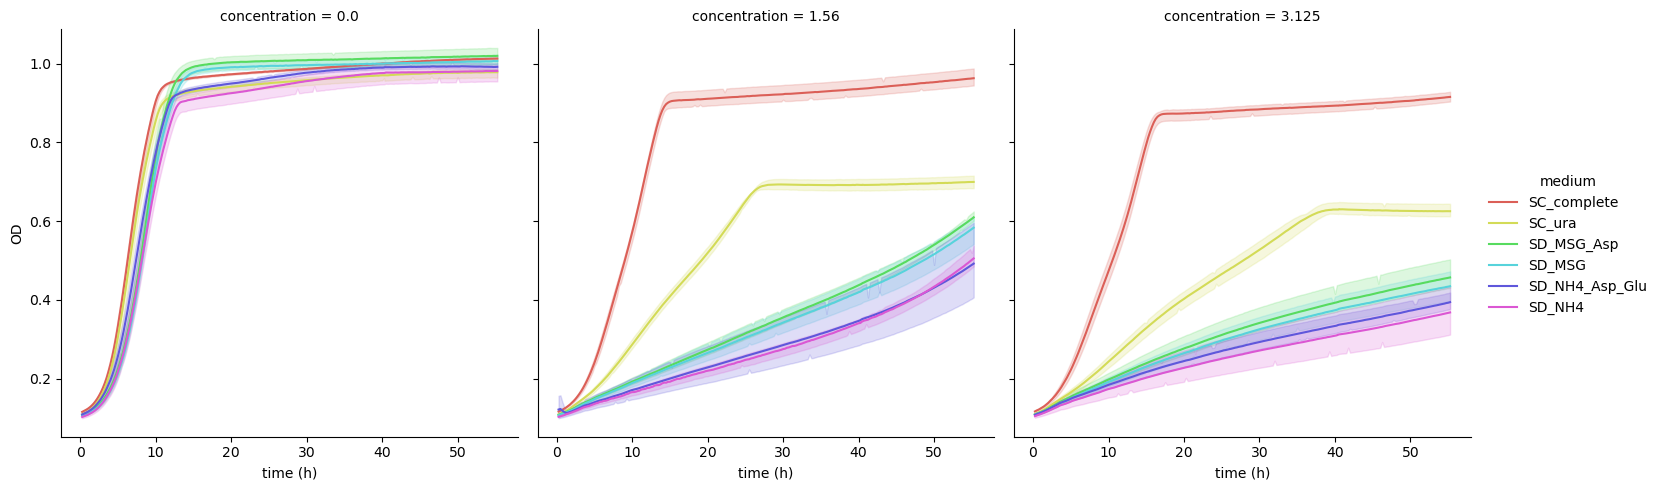

In [12]:
sns.relplot(data=merged[merged['time (h)'] > 0.2], x='time (h)', y='OD', hue='medium', palette='hls', col='concentration', kind='line')

## AUC

In [8]:
def get_auc(g):
    return np.trapz(g.OD)

In [9]:
aucdf = merged[merged['time (h)'] > 0.2].groupby(['medium','concentration','well'])[['OD']].apply(func=get_auc).reset_index(name='auc')
aucdf.head(6)

,medium,concentration,well,auc
0,SC_complete,0.00,B10,198.069695
1,SC_complete,0.00,B11,200.126060
2,SC_complete,0.00,B9,199.334395
3,SC_complete,1.56,B6,184.173920
4,SC_complete,1.56,B7,178.166645
5,SC_complete,1.56,B8,177.439730


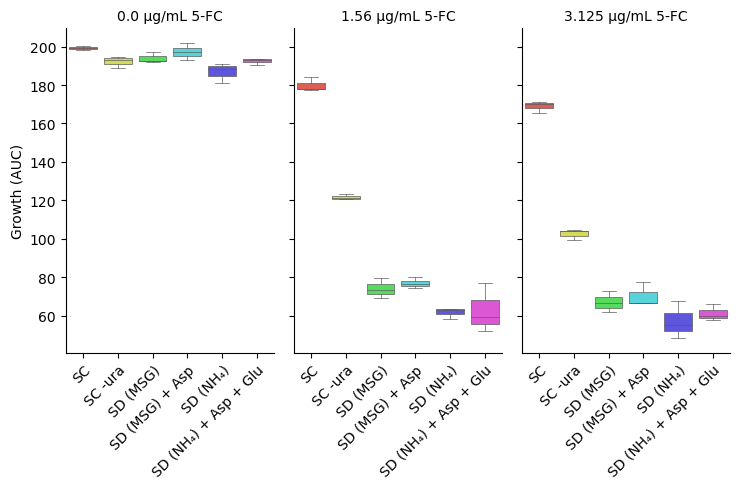

In [10]:
grid = sns.catplot(data=aucdf, x='medium', order=['SC_complete', 'SC_ura', 'SD_MSG', 'SD_MSG_Asp', 'SD_NH4', 'SD_NH4_Asp_Glu'],
                   y='auc', col='concentration',
                   hue='medium', palette='hls', saturation=1,
                   kind='box', dodge=False,
                   linewidth=0.5,
                   height=5, aspect=0.5
                  )

grid.set_titles(col_template='{col_name} μg/mL 5-FC')
grid.set_axis_labels('', 'Growth (AUC)')
for i in range(len(aucdf.concentration.unique())):
    grid.axes[0][i].set_xticklabels(['SC', 'SC -ura', 'SD (MSG)', 'SD (MSG) + Asp', 'SD (NH₄)', 'SD (NH₄) + Asp + Glu'],
                                    rotation=45, ha='right', rotation_mode='anchor')

#grid._legend.set_title('Inoculum')
#for i, v in enumerate(['WT',  u'Δ$\it{FCY1}$', u'Δ$\it{FUR1}$']):
#    grid._legend.texts[i].set_text(v)

grid.tight_layout()
plt.savefig(graph_outpath+'20230403_5FC_defined_medium.svg', format='svg', dpi=300)
plt.savefig(graph_outpath+'20230403_5FC_defined_medium.png', format='png', dpi=300)